Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/algosto/blob/master/python/TP_EM_GMM.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Falgosto&urlpath=tree%2Falgosto%2Fpython%2FTP_EM_GMM.ipynb&branch=master" target="_blank">Rosenblatt</a>

# TP Algorithmes EM et SEM pour mélanges de gaussiennes

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import scipy.stats as sps

In [2]:
#from TP_EM_GMM import *

$\newcommand{\R}{\mathbb{R}}$

## Rappels de cours

### Modèle de mélange gaussien
Un mélange gaussien en dimension $d$ est une loi de densité
$$f_\theta(x) = \sum_{k=1}^K \pi_k f_{\mu_k,\Sigma_k}(x),$$
où les poids $\pi_k$ forment un vecteur de probabilité, et la notation $f_{\mu,\Sigma}$ désigne la densité de la loi normale multidimensionnelle d'espérance $\mu\in\R^d$ et de matrice de covariance $\Sigma\in\R^{d\times d}$. On note $\theta=(\pi_k,\mu_k,\Sigma_k)_{1\leq k\leq K}$ l'ensemble des paramètres de ce mélange gaussien.

### Simulation des données

Pour simuler un échantillon d'une loi de mélange gaussien, on commence par simuler un échantillon $(Z_1,\ldots,Z_n)$ de loi donnée par $\mathbb{P}[Z_i=k]=\pi_k$ pour tout $k\in\{1,\ldots,K\}$, puis pour chaque $i$ on simule $X_i$ selon la loi de densité $f_{\theta_k}$, où $k=z_i$, valeur simulée de $Z_i$.

<font color='blue'> 1. Ecrire une fonction `sample_gaussian_mixture(n, pi, mu, Sigma)` permettant de simuler $n$ réalisations indépendantes d'une telle loi. *pi* est le vecteur des paramètres du mélange, de longueur *K*, *mu* les moyennes, données sous forme de tableau de taille (K,d), et *Sigma* les matrices de covariance, tableau de taille $(K,d,d)$. La fonction doit renvoyer à la fois les $x_i$ et les $z_i$. On pourra utiliser les fonctions `numpy.random.choice` et `numpy.random.multivariate_normal`.</font>

In [10]:
# 1. fonction pour simuler un mélange gaussien
def sample_gaussian_mixture(n, pi, mu, Sigma):
    K = len(pi)
    d = mu.shape[1]
    # tirer au sort les z_i:
    z = np.random.choice(K,size=n,p=pi)
    # initialisation de x:
    x = np.zeros((n,d))
    # tirer au sort les x_i:
    for k in range(K):
        nk = np.sum(z==k)
        x[z==k,:] = np.random.multivariate_normal(mean=mu[k,:],cov=Sigma[k,:,:],size=nk)
    return x,z

<font color='blue'> 2. Tester cette fonction d'abord en dimension $d=1$, avec $K=3$, $\pi=(.4,.3,.3)$, $\mu=(-4,4,0)$, $\Sigma=(1,1,1)$ et $n = 10000$ et tracer l'histogramme des réalisations ainsi obtenues.</font>

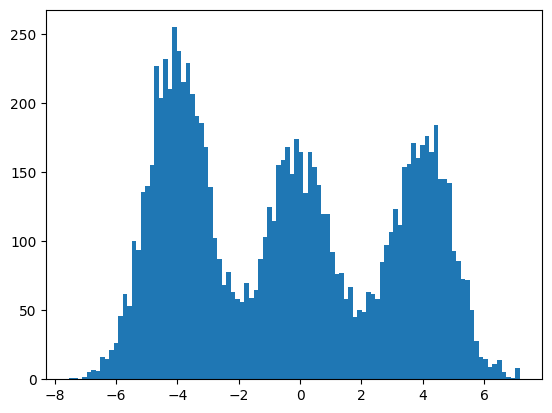

In [13]:
# 2. test en dimension 1
pi = np.array([.4,.3,.3])
mu = np.array([[-4],[4],[0]])
Sigma = np.array([[[1]],[[1]],[[1]]])
n = 10000
x,z = sample_gaussian_mixture(n, pi, mu, Sigma)
plt.hist(x, 100);

Voici à présent un exemple en dimension 2. Définissons d'abord une fonction d'affichage qui nous sera utile pour toute la suite:

In [14]:
def plot_gaussian_mixture_2d(mu, Sigma, x=None, z=None, axis_equal=True, title=""):
    K = mu.shape[0]
    if x is not None:
        c = "k" if z is None else z
        plt.scatter(x[:,0], x[:,1], s=.1, c=c)
    mu = mu[:,None,:,None]                            # (K,1,2,1)
    rSigma = np.array([sqrtm(Sigma[k]) for k in range(K)])
    rSigma = rSigma[:,None,:,:]                       # (K,1,2,2)
    t = np.linspace(0,2*np.pi)[None,:,None,None]      # (1,n,1,1)
    y = np.concatenate((np.cos(t),np.sin(t)),axis=2)  # (1,n,2,1)
    y = 2*rSigma @ y + mu                             # (K,n,2,1)
    plt.plot(y[:,:,0,0].T,y[:,:,1,0].T)
    if axis_equal:
        plt.axis("equal")
    plt.title(title)
    plt.show()

On teste à présent la fonction `sample_gaussian_mixture` pour $d=2$, d'abord dans un cas simple, avec $K=2$ et des gaussiennes de covariance égales à la matrice identité mais de moyennes différentes, et on affiche:

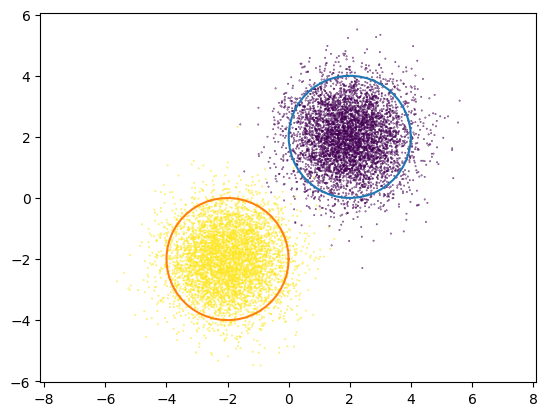

In [15]:
n = 10000
pi = np.array([.5,.5])
mu = np.array([[2,2],[-2,-2]])
Sigma = np.array([np.eye(2),np.eye(2)])
x, z = sample_gaussian_mixture(n, pi, mu, Sigma)
plot_gaussian_mixture_2d(mu,Sigma,x,z)

A présent on teste un cas un peu plus compliqué avec $K=4$ et des matrices de covariances non identiques. Ce cas nous servira ensuite pour tester les algorithmes EM:

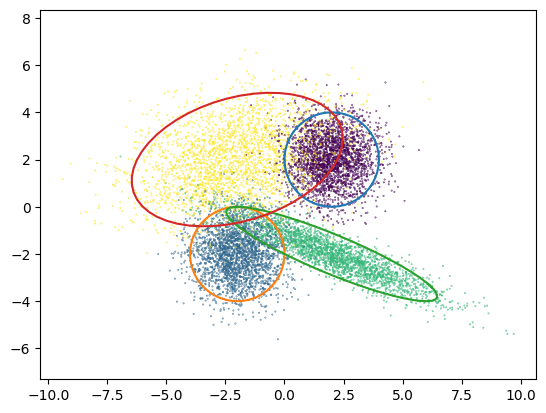

In [16]:
n = 10000
pi = [.25,.25,.25,.25]
mu = np.array([[2,2],[-2,-2],[2,-2],[-2,2]])
P, Q = np.array([[2,1],[-1,0]]), np.array([[-2,1],[-1,-1]])
Sigma = np.array([np.eye(2),np.eye(2),P@P.T,Q@Q.T])
x, z = sample_gaussian_mixture(n, pi, mu, Sigma)
plot_gaussian_mixture_2d(mu,Sigma,x,z)

### Algorithme EM

L'algorithme EM permet d'estimer les paramètres d'un mélange gaussien. On rappelle ici ses étapes:
- On se donne en entrée des observations $\mathbf{x} = (x_1,\dots,x_n)$, supposées être des réalisations i.i.d. des $X_i$, et des paramètres initiaux
$\theta^0 = (\pi_k^0,\mu_k^0,\Sigma_k^0)_{1\leq k\leq K} $
- Tant qu'on n'a pas convergé, itérer :
  -  __Etape E__: calculer pour tout $i$ dans $\{1,\dots,n\}$ et
tout $k$ dans $\{1,\dots,K\}$ les valeurs
$$\gamma_{ik}^{t} =\frac{\pi_{k}^t g_{\mu_{k}^t, \Sigma_k^t}(x_i)}{\sum_{j=1}^K\pi_{j}^tg_{\mu_{j}^t,\Sigma_j^t}(x_i)}.$$
  - __Etape M__:  mettre à jour les paramètres
\begin{align*} \mu_k^{t+1} &= \frac{1}{\sum_{i=1}^n \gamma_{ik}^{t}}\sum_{i=1}^n
 \gamma_{ik}^t x_i.
 \\\Sigma_k^{t+1} &= \frac{1}{\sum_{i=1}^n \gamma_{ik}^t}\sum_{i=1}^n
  \gamma_{ik}^t (x_i- \mu_k^{t+1}) (x_i- \mu_k ^{t+1})^T,
  \\\pi_k^{t+1} &= \frac 1 n \sum_{i=1}^n \gamma_{ik}^t.\end{align*}

Voici d'abord une fonction pour définir des paramètres initiaux:

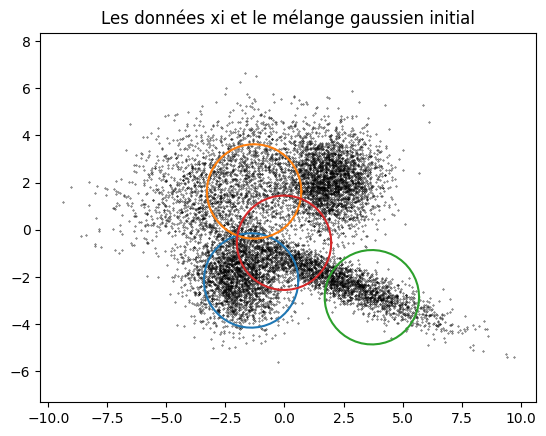

In [17]:
def init_EM(x,K):
    n, d = x.shape
    pi0 = np.ones(K)/K
    mu0 = np.mean(x,axis=0)[None,:] + np.random.randn(K,d) * np.std(x,axis=0)[None,:]
    Sigma0 = np.repeat(np.eye(2)[None,:,:],K,axis=0)
    return pi0, mu0, Sigma0

K = 4
pi0, mu0, Sigma0 = init_EM(x,K)
plot_gaussian_mixture_2d(mu0,Sigma0,x, title="Les données xi et le mélange gaussien initial");

<font color='blue'> 3. Ecrire une fonction `EM_gaussian_mixture(x, K, niter=50)` permettant d'effectuer *niter* itérations de l'algorithme EM pour les données $x_i$ et le nombre de composantes $K$. Les paramètres initiaux seront choisis avec la fonction `init_EM`, et on pourra utiliser la fonction `scipy.stats.multivariate_normal.pdf`</font>

In [ ]:
# 3. fonction pour l'algorithme EM
def EM_gaussian_mixture(x, K, niter=50):
    n = x.shape[0]
    pi, mu, Sigma = init_EM(x,K)
    gamma = np.zeros((n,K))
    for t in range[niter]:
        # étape E: calcul des gamma_ik à partir des pi_k, mu_k, Sigma_k
        for k in range(K):
            gamma[:,k] = pi[k] * sps.multivariate_normal.pdf(x,mu[k,:],Sigma[k,:,:])
        gamma = gamma / np.sum(gamma,axis=1,keepdims=True)
        # étape M: calcul des pi_k, mu_k, Sigma_k à partir des gamma_ik
        # ... à terminer ...
    

On teste à présent l'algorithme sur les données simulées précédentes.

In [ ]:
K = 4
pi, mu, Sigma, gamma = EM_gaussian_mixture(x, K)

# affichage
z = np.argmax(gamma,axis=0)
plot_gaussian_mixture_2d(mu,Sigma,x,z, title="Résultat de l'algorithme EM")

### Algorithme SEM

$\newcommand{\one}{\mathbb{1}}$

L'algorithme SEM (Stochastic EM) est une variante introduisant une composante aléatoire dans les itérations.
Après le calcul des $\gamma_{ik}^t$, on tire pour chaque
$i$ une réalisation $z_i$ d'une variable $Z_i$ dans $\{1,\dots,K\}$ ayant
pour loi  $(\gamma_{i1}^t,\dots,\gamma_{iK}^t)$. Ces réalisations $z_i$ sont ensuite utilisées pour mettre à jour
les moyennes, covariances et poids du GMM.

- On se donne en entrée des observations $\mathbf{x} = (x_1,\dots,x_n)$, supposées être des réalisations i.i.d. des $X_i$, et des paramètres initiaux
$\theta^0 = (\pi_k^0,\mu_k^0,\Sigma_k^0)_{1\leq k\leq K} $
- Tant qu'on n'a pas convergé, itérer :
  - __Etape E__: calculer pour tout $i$ dans $\{1,\dots,n\}$ et
tout $k$ dans $\{1,\dots,K\}$ les valeurs
$$\gamma_{ik}^{t} =\frac{\pi_{k}^t g_{\mu_{k}^t, \Sigma_k^t}(x_i)}{\sum_{j=1}^K\pi_{j}^tg_{\mu_{j}^t,\Sigma_j^t}(x_i)}.$$
  - __Etape S__:  pour tout
$i$ dans $\{1,\dots,n\}$, tirer une réalisation $z_i^t$ d'une variable $Z_i^t$ dans $\{1,\dots,K\}$ ayant
pour loi  $(\gamma_{i1}^t,\dots,\gamma_{iK}^t)$
  - __Etape M__:  mettre à jour les paramètres
\begin{align*}
\mu_k^{t+1} &= \frac{1}{n_k^t}\sum_{i, z_i^t = k} x_i.
\\ \Sigma_k^{t+1} &= \frac{1}{n_k^t}\sum_{i, z_i^t = k}(x_i- \mu_k^{t+1}) (x_i- \mu_k ^{t+1})^T,
\\ \pi_k^{t+1} &= \frac {n_k^t} n,
\end{align*}
où $n_k^t=|\{i,z_i^t = k\}|$.

<font color='blue'>4. Ecrire une fonction `SEM_gaussian_mixture(x, K, niter=50)` écrite sur le modèle de la fonction précédente mais modifiée afin de réaliser l'algorithme SEM. Pour l'étape S on utilisera la fonction `numpy.random.choice`.</font>

In [ ]:
# 4. fonction pour l'algorithme SEM
# TODO

In [ ]:
K = 4
pi, mu, Sigma, gamma = SEM_gaussian_mixture(x, K)

# affichage
z = np.argmax(gamma,axis=0)
plot_gaussian_mixture_2d(mu,Sigma,x,z, title="Résultat de l'algorithme SEM")

On peut remarquer que la fonction `SEM_gaussian_mixture` est assez lente. Pour améliorer ceci, voici une fonction spécifique permettant de simuler directement, à partir de vecteurs $\gamma_i$, les variables $z_i$:

In [ ]:
def batch_random_choice(gamma):
    K, n = gamma.shape
    z = np.zeros(n)
    r = np.random.rand(n)
    a = np.zeros(n)
    for k in range(K):
        b = a + gamma[k,:]
        z[(a<=r)&(r<b)] = k
        a = b
    return z

<font color='blue'>5. Expliquer pourquoi la fonction `batch_random_choice` permet bien de simuler chaque $z_i$ suivant la loi donnée par $\gamma_i$. Ecrire une fonction `SEM_gaussian_mixture_fast(x, K, niter=50)` en utilisant `batch_random_choice` pour l'étape S, puis testez là pour observer le gain de temps. Pourquoi la fonction est-elle beaucoup plus rapide?
</font>

In [ ]:
# 5. fonction pour l'algorithme SEM (version rapide)
# TODO

In [ ]:
K = 4
pi, mu, Sigma, gamma = SEM_gaussian_mixture_fast(x, K)

# affichage
z = np.argmax(gamma,axis=0)
plot_gaussian_mixture_2d(mu,Sigma,x,z, title="Résultat de l'algorithme SEM")

### Application à des données non simulées

Nous allons à présent étudier des données issues de l'article suivant :

- Bachrach LK, Hastie T, Wang M-C, Narasimhan B, Marcus R. *Bone Mineral Acquisition in Healthy Asian, Hispanic, Black and Caucasian Youth. A Longitudinal Study.* J Clin Endocrinol Metab (1999) 84, 4702-12.

Elles représentent des mesures relatives de densité minérale osseuse spinale sur des adolescents  nord-américains. Chaque valeur est la différence de mesures prises sur deux visites consécutives, divisées par la moyenne.

L'idée est de savoir si la population peut être décrite par un mélange de deux gaussiennes.
Le but est donc d'appliquer à ces données l'algorithme EM, vérifier que le $K$ optimal de la méthode de sélection de modèle vue en cours est bien $K=2$ et proposer un clustering de ces observations.

On commence par créer le tableau de donnees à partir du fichier, et afficher les points.

In [ ]:
x = np.loadtxt("../data/densitesOs.txt")
n,d = x.shape
plt.scatter(x[:,0], x[:,1], s=1, c="k")
plt.title(f"Les {n} points du dataset");

<font color='blue'>6. Appliquer la méthode EM à ces données pour des valeurs de $K$ entre $1$ et $5$, et afficher à chaque fois le résultat (on utilisera l'option `axis_equal=False` dans la fonction `plot_gaussian_mixture_2d`).
</font>

In [ ]:
# 6. EM sur les données réelles pour K entre 1 et 5
# TODO

question_6(x)

## Sélection de modèle

Pour la sélection de modèle, il faut calculer la log-vraisemblance et la complexité du modèle.

Une manière classique de choisir le nombre de composantes $K$ dans un intervalle d'entiers est d'utiliser le critère BIC qui consiste à minimiser en $K$
 $$-\ell(x;\widehat{\theta}_K)+ \frac{\operatorname{dim}_K \times \log n}{2},$$
 avec
 + $\widehat{\theta}_K$ l'estimateur de $\theta$ issu de l'algorithme EM dans le modèle de mélange avec $K$ classes,
 + $\ell(x;\hat{\theta}_K)$ la  log-vraisemblance de l'échantillon   observé $(x_1,\dots , x_n)$
 + $\operatorname{dim}_K$ le nombre de degrés de liberté   du modèle de mélange utilisé avec $K$ classes (voir le cours).

Le K optimal pour la sélection de modèle est l'argmin de cette fonction.

<font color='blue'>7. Ecrire une fonction `log_likelihood(x,pi,mu,Sigma)` permettant de calculer la vraisemblance du GMM donné par les paramètres (pi,mu,Sigma) sur les données `x`.
</font>

In [ ]:
# 7. fonction pour le calcul de la log-vraisemblance
# TODO

<font color='blue'>8. Implémenter la sélection de modèle et l'appliquer aux données précédentes pour déterminer le K optimal. Afficher également la fonction  $-\ell(x;\widehat{\theta}_K)+ \frac{\operatorname{dim}_K \times \log n}{2},$ en fonction de $K$. Commentez les résultats.
</font>

In [ ]:
# 8. sélection de modèle par critère BIC sur les données réelles.
# TODO

selec_model(x)